## General Scheme of Optimal Method

In [1]:
import numpy as np
from autograd import grad, hessian
from typing import Callable

In [2]:
def objective_function(X: np.ndarray, L: int = 1):
    """
    The objective function.
    X: the input, which is a array. By default X is a 3-dimensional array.
    L: the parameter, by default it is 1.
    """
    temp = 0
    shape = X.shape[0]

    for i in range(shape)[:-1]:
        temp = temp + (X[i] - X[i+1]) ** 2
    temp = temp + X[0] ** 2
    temp = temp + X[shape-1] ** 2
    temp = temp / 2
    temp = temp - X[0]

    return L / 4 * temp

In [3]:
# test the objective function is right
X_best = np.array([0.75, 0.5, 0.25])
y_best = objective_function(X_best)
y_best

-0.09375

In [4]:
# Try to calculate the constants of the objective function.

# For this objective, the hessian matrix is L/4*A
A = np.array([[2, -1, 0],
              [-1, 2, -1],
              [0, -1, 2]])

# Calculate the eigenvalue.
eigenvalues = np.linalg.eigvals(A)

# Calculate the strong convexity coefficient.
convexity_coefficient = np.min(eigenvalues)
print("Strong convexity coefficient:", convexity_coefficient)

# Calculate the Lipschitz constant.
lipschitz_constant = np.max(eigenvalues)
print("Lipschitz constant:", lipschitz_constant)

Strong convexity coefficient: 0.5857864376269049
Lipschitz constant: 3.4142135623730914


In [5]:
# Some optimization functions for solving the learning rate.
def damping_step_generator(lr: float = 1, is_constant: bool = True):
    """
    Attention: this is a function generator for generating a damping_step function!
    This is done to make it easy to adjust the learning rate outside of the call.
    """
    def f(x, obj_function, n_iter, lr=lr, is_constant=is_constant):
        if is_constant:
            return lr
        else:
            return lr/np.sqrt(1+n_iter)
    return f


def newton_method(x, obj_function, n_iter):
    """
    Calculating learning rates using Newton's method.
    """
    hessian_newton = hessian(objective_function)
    return np.linalg.inv(hessian_newton(x))


def damped_newton_method_generator(alpha=0.01, beta=0.5):
    """
    Attention: this is a function generator for generating a damped newton method!
    This is done to make it easy to adjust the learning rate outside of the call.
    """
    def f(x, obj_function, n_iter, alpha=alpha, beta=beta):
        hessian_newton = hessian(objective_function)
        grad_x = grad(obj_function)(x)
        hessian_inv = np.linalg.inv(hessian_newton(x))
        d = -np.dot(hessian_inv, grad_x)
        gamma = 1.0
        while obj_function(x + gamma * d) > obj_function(x) \
                + alpha * gamma * np.dot(grad_x.T, d):
            gamma = gamma * beta

        return gamma * np.linalg.inv(hessian_newton(x))
    return f

In [6]:
def calculate_alpha(L, mu, gamma):
    a = L
    b = gamma - mu
    c = -gamma
    roots = np.roots([a, b, c])
    res = np.nan
    for root in roots:
        if 0 < root < 1:
            res = root
    return res


def general_scheme_of_optimal_method(initial_x: np.ndarray, gamma_0: float, max_iters: int, obj_function: Callable, optim_function: Callable, is_log: bool = True):
    """general scheme of optimal method, which are often addressed as Fast Gradient Methods.
    initial_x: The initial value of the iteration.
    gamma_0: The initial value of gamma
    max_iters: Maximum number of iterations.
    obj_function: The objective function.
    optim_function: The optimization function.
    is_log: Used to log the gradient descent procedure.
    """
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    grad_matrix = grad(obj_function)
    # Define some parameters for iteration
    gamma = gamma_0
    v = initial_x
    # For this objective, the Lipschitz constant is L, which is 1.
    L = 1
    # For this objective, the convexity parameter is L/8, which is 0.125.
    mu = 0.125

    for n_iter in range(max_iters):
        # Calculate the alpha and gamma[k+1]
        alpha = calculate_alpha(L, mu, gamma)
        new_gamma = (1 - alpha) * gamma + alpha * mu
        # Choose the y
        y = 1/(gamma+alpha*mu)*(alpha*gamma*v+new_gamma*x)
        # Set the learning rate
        learning_rate = optim_function(y, obj_function, n_iter)
        # update x by a gradient descent step
        x = y - np.dot(learning_rate, grad_matrix(y))
        # Update v and gamma
        v = 1/new_gamma*((1-alpha)*gamma*v+alpha*mu*y-alpha*grad_matrix(y))
        gamma = new_gamma
        # Store x and objective function value
        obj = obj_function(x)
        xs.append(x)
        objectives.append(obj)

        if is_log:
            print(
                f"Fast Gradient Methods({n_iter}/{max_iters}): objective={obj}")

    return objectives, xs

In [7]:
init_x = np.array([0., 0., 0.])
gamma_0 = 0.


general_scheme_of_optimal_method(
    init_x, gamma_0, 100, objective_function, damping_step_generator(lr=0.1))

Fast Gradient Methods(0/100): objective=-0.00609375
Fast Gradient Methods(1/100): objective=-0.0387621914927422
Fast Gradient Methods(2/100): objective=-0.06316859856876009
Fast Gradient Methods(3/100): objective=-0.07510857470029195
Fast Gradient Methods(4/100): objective=-0.08256094203780884
Fast Gradient Methods(5/100): objective=-0.08782195737301858
Fast Gradient Methods(6/100): objective=-0.09100793560947747
Fast Gradient Methods(7/100): objective=-0.09262470216918628
Fast Gradient Methods(8/100): objective=-0.09329049182268895
Fast Gradient Methods(9/100): objective=-0.09354006746471673
Fast Gradient Methods(10/100): objective=-0.09365956617597426
Fast Gradient Methods(11/100): objective=-0.0937208538731057
Fast Gradient Methods(12/100): objective=-0.09374276935611979
Fast Gradient Methods(13/100): objective=-0.0937476477333681
Fast Gradient Methods(14/100): objective=-0.09374889240531417
Fast Gradient Methods(15/100): objective=-0.09374958615164958
Fast Gradient Methods(16/100):

Fast Gradient Methods(80/100): objective=-0.09375
Fast Gradient Methods(81/100): objective=-0.09375
Fast Gradient Methods(82/100): objective=-0.09374999999999999
Fast Gradient Methods(83/100): objective=-0.09375
Fast Gradient Methods(84/100): objective=-0.09375
Fast Gradient Methods(85/100): objective=-0.09375
Fast Gradient Methods(86/100): objective=-0.09375
Fast Gradient Methods(87/100): objective=-0.09374999999999999
Fast Gradient Methods(88/100): objective=-0.09375
Fast Gradient Methods(89/100): objective=-0.09375
Fast Gradient Methods(90/100): objective=-0.09374999999999999
Fast Gradient Methods(91/100): objective=-0.09375
Fast Gradient Methods(92/100): objective=-0.09374999999999999
Fast Gradient Methods(93/100): objective=-0.09375
Fast Gradient Methods(94/100): objective=-0.09375
Fast Gradient Methods(95/100): objective=-0.09375
Fast Gradient Methods(96/100): objective=-0.09374999999999999
Fast Gradient Methods(97/100): objective=-0.09375
Fast Gradient Methods(98/100): objective

([-0.00609375,
  -0.0387621914927422,
  -0.06316859856876009,
  -0.07510857470029195,
  -0.08256094203780884,
  -0.08782195737301858,
  -0.09100793560947747,
  -0.09262470216918628,
  -0.09329049182268895,
  -0.09354006746471673,
  -0.09365956617597426,
  -0.0937208538731057,
  -0.09374276935611979,
  -0.0937476477333681,
  -0.09374889240531417,
  -0.09374958615164958,
  -0.09374989480077861,
  -0.09374996224807068,
  -0.09374995469482893,
  -0.09374995344476972,
  -0.09374996814898184,
  -0.09374998266344498,
  -0.09374999034446561,
  -0.09374999416272503,
  -0.09374999667802708,
  -0.09374999832300074,
  -0.09374999921072942,
  -0.09374999963029325,
  -0.09374999982509921,
  -0.09374999991986367,
  -0.09374999996638532,
  -0.09374999998718413,
  -0.09374999999521309,
  -0.09374999999814701,
  -0.09374999999933072,
  -0.09374999999981129,
  -0.09374999999996365,
  -0.0937499999999938,
  -0.09374999999999634,
  -0.09374999999999695,
  -0.09374999999999789,
  -0.09374999999999842,
  -0.

In [8]:
def calculate_alpha(L, mu, gamma):
    a = L
    b = gamma - mu
    c = -gamma
    roots = np.roots([a, b, c])
    res = np.nan
    for root in roots:
        if 0 < root < 1:
            res = root
    return res


def constant_step_scheme_1(initial_x: np.ndarray, gamma_0: float, max_iters: int, obj_function: Callable, is_log: bool = True):
    """Improvement 1 to the FGM methodology, which fixed descent step
    initial_x: The initial value of the iteration.
    gamma_0: The initial value of gamma
    max_iters: Maximum number of iterations.
    obj_function: The objective function.
    is_log: Used to log the gradient descent procedure.
    """
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    grad_matrix = grad(obj_function)
    # Define some parameters for iteration
    gamma = gamma_0
    v = initial_x
    # For this objective, the Lipschitz constant is L, which is 1.
    L = 1
    # For this objective, the convexity parameter is L/8, which is 0.125.
    mu = 0.125

    for n_iter in range(max_iters):
        # Calculate the alpha and gamma[k+1]
        alpha = calculate_alpha(L, mu, gamma)
        new_gamma = (1 - alpha) * gamma + alpha * mu
        # Choose the y
        y = 1/(gamma+alpha*mu)*(alpha*gamma*v+new_gamma*x)
        # Update x by a gradient descent step
        x = y - 1/L*grad_matrix(y)
        # Update v and gamma
        v = 1/new_gamma*((1-alpha)*gamma*v+alpha*mu*y-alpha*grad_matrix(y))
        gamma = new_gamma
        # Store x and objective function value
        obj = obj_function(x)
        xs.append(x)
        objectives.append(obj)

        if is_log:
            print(
                f"Fast Gradient Methods({n_iter}/{max_iters}): objective={obj}")

    return objectives, xs

In [9]:
init_x = np.array([0., 0., 0.])
gamma_0 = 0.

constant_step_scheme_1(init_x, gamma_0, 100, objective_function)

Fast Gradient Methods(0/100): objective=-0.046875
Fast Gradient Methods(1/100): objective=-0.06988930235537448
Fast Gradient Methods(2/100): objective=-0.08167058174729999
Fast Gradient Methods(3/100): objective=-0.088234705918824
Fast Gradient Methods(4/100): objective=-0.09157118276757818
Fast Gradient Methods(5/100): objective=-0.09298934237189706
Fast Gradient Methods(6/100): objective=-0.09351055824653179
Fast Gradient Methods(7/100): objective=-0.09368330828378037
Fast Gradient Methods(8/100): objective=-0.09373464098146492
Fast Gradient Methods(9/100): objective=-0.09374751557351005
Fast Gradient Methods(10/100): objective=-0.0937498558411228
Fast Gradient Methods(11/100): objective=-0.09374997262153584
Fast Gradient Methods(12/100): objective=-0.09374986858467385
Fast Gradient Methods(13/100): objective=-0.09374984798430012
Fast Gradient Methods(14/100): objective=-0.09374988160570898
Fast Gradient Methods(15/100): objective=-0.09374992434292469
Fast Gradient Methods(16/100): o

Fast Gradient Methods(22/100): objective=-0.09374999966995809
Fast Gradient Methods(23/100): objective=-0.09374999987803509
Fast Gradient Methods(24/100): objective=-0.09374999995745596
Fast Gradient Methods(25/100): objective=-0.09374999998612975
Fast Gradient Methods(26/100): objective=-0.09374999999584603
Fast Gradient Methods(27/100): objective=-0.09374999999889268
Fast Gradient Methods(28/100): objective=-0.09374999999975368
Fast Gradient Methods(29/100): objective=-0.0937499999999612
Fast Gradient Methods(30/100): objective=-0.09374999999999788
Fast Gradient Methods(31/100): objective=-0.0937499999999995
Fast Gradient Methods(32/100): objective=-0.09374999999999781
Fast Gradient Methods(33/100): objective=-0.0937499999999975
Fast Gradient Methods(34/100): objective=-0.09374999999999807
Fast Gradient Methods(35/100): objective=-0.09374999999999876
Fast Gradient Methods(36/100): objective=-0.0937499999999993
Fast Gradient Methods(37/100): objective=-0.09374999999999964
Fast Gradien

([-0.046875,
  -0.06988930235537448,
  -0.08167058174729999,
  -0.088234705918824,
  -0.09157118276757818,
  -0.09298934237189706,
  -0.09351055824653179,
  -0.09368330828378037,
  -0.09373464098146492,
  -0.09374751557351005,
  -0.0937498558411228,
  -0.09374997262153584,
  -0.09374986858467385,
  -0.09374984798430012,
  -0.09374988160570898,
  -0.09374992434292469,
  -0.09374995730563179,
  -0.09374997796108953,
  -0.09374998939238419,
  -0.09374999518717893,
  -0.09374999792896974,
  -0.09374999915236024,
  -0.09374999966995809,
  -0.09374999987803509,
  -0.09374999995745596,
  -0.09374999998612975,
  -0.09374999999584603,
  -0.09374999999889268,
  -0.09374999999975368,
  -0.0937499999999612,
  -0.09374999999999788,
  -0.0937499999999995,
  -0.09374999999999781,
  -0.0937499999999975,
  -0.09374999999999807,
  -0.09374999999999876,
  -0.0937499999999993,
  -0.09374999999999964,
  -0.09374999999999983,
  -0.09374999999999993,
  -0.09374999999999996,
  -0.09374999999999999,
  -0.09375

In [10]:
def calculate_alpha_by_alpha(L, mu, alpha):
    a = 1
    b = alpha**2 - mu/L
    c = -alpha**2
    roots = np.roots([a, b, c])
    res = np.nan
    for root in roots:
        if 0 < root < 1:
            res = root
    return res


def constant_step_scheme_2(initial_x: np.ndarray, alpha_0: float, max_iters: int, obj_function: Callable, is_log: bool = True):
    """Improvement 2 to the FGM methodology, which eliminated the sequence gamma and v.
    initial_x: The initial value of the iteration.
    alpha_0: The initial value of gamma.
    max_iters: Maximum number of iterations.
    obj_function: The objective function.
    is_log: Used to log the gradient descent procedure.
    """
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    y = initial_x
    grad_matrix = grad(obj_function)
    # Define some parameters for iteration
    alpha = alpha_0
    L = 1       # For this objective, the Lipschitz constant is L, which is 1.
    # For this objective, the convexity parameter is L/8, which is 0.125.
    mu = 0.125

    for n_iter in range(max_iters):
        # Calculate x by a gradient descent step
        new_x = y - 1/L * grad_matrix(y)
        # Calculate the alpha
        new_alpha = calculate_alpha_by_alpha(L, mu, alpha)
        # Choose the y
        beta = alpha * (1 - alpha) / (alpha**2 + new_alpha)
        # Update x by a gradient descent step
        y = new_x + beta * (new_x - x)
        # Update x and alpha
        x = new_x
        alpha = new_alpha
        # Store x and objective function value
        obj = obj_function(x)
        xs.append(x)
        objectives.append(obj)

        if is_log:
            print(
                f"Fast Gradient Methods({n_iter}/{max_iters}): objective={obj}")

    return objectives, xs

In [11]:
init_x = np.array([0., 0., 0.])
alpha_0 = 0.

constant_step_scheme_2(init_x, alpha_0, 100, objective_function)

Fast Gradient Methods(0/100): objective=-0.046875
Fast Gradient Methods(1/100): objective=-0.0634765625
Fast Gradient Methods(2/100): objective=-0.07658646370002073
Fast Gradient Methods(3/100): objective=-0.08498687596920856
Fast Gradient Methods(4/100): objective=-0.0898033384671622
Fast Gradient Methods(5/100): objective=-0.09218681536104627
Fast Gradient Methods(6/100): objective=-0.09319822521033826
Fast Gradient Methods(7/100): objective=-0.09357555882232611
Fast Gradient Methods(8/100): objective=-0.09370160100534267
Fast Gradient Methods(9/100): objective=-0.09373890425958294
Fast Gradient Methods(10/100): objective=-0.09374820491095659
Fast Gradient Methods(11/100): objective=-0.09374989524952797
Fast Gradient Methods(12/100): objective=-0.09374998034431131
Fast Gradient Methods(13/100): objective=-0.09374990453278646
Fast Gradient Methods(14/100): objective=-0.09374988931563952
Fast Gradient Methods(15/100): objective=-0.0937499137477908
Fast Gradient Methods(16/100): objecti

([-0.046875,
  -0.0634765625,
  -0.07658646370002073,
  -0.08498687596920856,
  -0.0898033384671622,
  -0.09218681536104627,
  -0.09319822521033826,
  -0.09357555882232611,
  -0.09370160100534267,
  -0.09373890425958294,
  -0.09374820491095659,
  -0.09374989524952797,
  -0.09374998034431131,
  -0.09374990453278646,
  -0.09374988931563952,
  -0.0937499137477908,
  -0.09374994487995568,
  -0.09374996889552485,
  -0.09374998394372373,
  -0.09374999227181588,
  -0.09374999649360298,
  -0.09374999849114506,
  -0.09374999938244993,
  -0.09374999975954701,
  -0.09374999991114205,
  -0.09374999996900439,
  -0.09374999998989479,
  -0.09374999999697362,
  -0.09374999999919326,
  -0.09374999999982055,
  -0.09374999999997174,
  -0.09374999999999845,
  -0.09374999999999964,
  -0.0937499999999984,
  -0.09374999999999818,
  -0.09374999999999858,
  -0.09374999999999911,
  -0.09374999999999951,
  -0.09374999999999974,
  -0.09374999999999989,
  -0.09374999999999994,
  -0.09374999999999997,
  -0.09375,
 

In [12]:
def constant_step_scheme_3(initial_x: np.ndarray, max_iters: int, obj_function: Callable, is_log: bool = True):
    """Improvement 3 to the FGM methodology, which eliminated the sequence alpha.
    initial_x: The initial value of the iteration.
    alpha_0: The initial value of gamma.
    max_iters: Maximum number of iterations.
    obj_function: The objective function.
    is_log: Used to log the gradient descent procedure.
    """
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    y = initial_x
    grad_matrix = grad(obj_function)
    # Define some parameters for iteration
    L = 1       # For this objective, the Lipschitz constant is L, which is 1.
    # For this objective, the convexity parameter is L/8, which is 0.125.
    mu = 0.125
    sqrt_q = np.sqrt(mu/L)
    for n_iter in range(max_iters):
        # Calculate x by a gradient descent step
        new_x = y - 1/L * grad_matrix(y)
        # Update y by a gradient descent step
        y = new_x + (1 - sqrt_q) / (1 + sqrt_q) * (new_x - x)
        # Update x
        x = new_x
        # Store x and objective function value
        obj = obj_function(x)
        xs.append(x)
        objectives.append(obj)

        if is_log:
            print(
                f"Fast Gradient Methods({n_iter}/{max_iters}): objective={obj}")

    return objectives, xs

In [13]:
init_x = np.array([0., 0., 0.])

constant_step_scheme_3(init_x, 100, objective_function)

Fast Gradient Methods(0/100): objective=-0.046875
Fast Gradient Methods(1/100): objective=-0.06933789885647193
Fast Gradient Methods(2/100): objective=-0.08062683897734321
Fast Gradient Methods(3/100): objective=-0.08705244133025092
Fast Gradient Methods(4/100): objective=-0.0905866260073584
Fast Gradient Methods(5/100): objective=-0.09234491583514377
Fast Gradient Methods(6/100): objective=-0.09315511994601174
Fast Gradient Methods(7/100): objective=-0.09350963765050457
Fast Gradient Methods(8/100): objective=-0.09365764648600945
Fast Gradient Methods(9/100): objective=-0.09371638670447355
Fast Gradient Methods(10/100): objective=-0.09373847691008788
Fast Gradient Methods(11/100): objective=-0.09374632006399089
Fast Gradient Methods(12/100): objective=-0.09374892732230553
Fast Gradient Methods(13/100): objective=-0.0937497252429072
Fast Gradient Methods(14/100): objective=-0.09374994294641253
Fast Gradient Methods(15/100): objective=-0.09374999232978533
Fast Gradient Methods(16/100): 

([-0.046875,
  -0.06933789885647193,
  -0.08062683897734321,
  -0.08705244133025092,
  -0.0905866260073584,
  -0.09234491583514377,
  -0.09315511994601174,
  -0.09350963765050457,
  -0.09365764648600945,
  -0.09371638670447355,
  -0.09373847691008788,
  -0.09374632006399089,
  -0.09374892732230553,
  -0.0937497252429072,
  -0.09374994294641253,
  -0.09374999232978533,
  -0.09374999982818227,
  -0.09374999963144004,
  -0.0937499991272712,
  -0.09374999913363498,
  -0.0937499993710024,
  -0.09374999961458612,
  -0.093749999788702,
  -0.09374999989329114,
  -0.09374999994955321,
  -0.09374999997746802,
  -0.09374999999044392,
  -0.09374999999614382,
  -0.09374999999852017,
  -0.09374999999946165,
  -0.09374999999981556,
  -0.09374999999994117,
  -0.09374999999998289,
  -0.09374999999999564,
  -0.0937499999999991,
  -0.09374999999999989,
  -0.09375,
  -0.09374999999999999,
  -0.09375,
  -0.09374999999999997,
  -0.09374999999999999,
  -0.09375,
  -0.09375,
  -0.09374999999999999,
  -0.09374

## Visulization 

In [14]:
# Plotting of contour plots
from ipywidgets import interact
import matplotlib.pyplot as plt

# Choose the maximum number and minimun number of X

MAX_X_1 = 10.0
MIN_X_1 = -10.0
MAX_X_2 = 10.0
MIN_X_2 = -10.0
MAX_X_3 = 10.0
MIN_X_3 = -10.0

# Describe the plotting accuracy
num_intervals = 500


def draw_counter_plot(fix, fixed_number):
    x_1 = np.linspace(MIN_X_1, MAX_X_1, num_intervals)
    x_2 = np.linspace(MIN_X_2, MAX_X_2, num_intervals)
    x_3 = np.linspace(MIN_X_3, MAX_X_3, num_intervals)

    x_left_name = ''
    x_right_name = ''
    x_left = np.array([])
    x_right = np.array([])
    Y = np.zeros(num_intervals)
    # Fix variables by parameters.
    match fix:
        case 'x1':
            x_left_name = 'x2'
            x_right_name = 'x3'
            x_left, x_right = np.meshgrid(x_2, x_3)
            x_fixed = fixed_number
            # Calculate the result.
            Y = np.array([[objective_function(np.array([x_fixed, xl, xr])) for xl, xr in zip(
                xl_row, xr_row)] for xl_row, xr_row in zip(x_left, x_right)])
        case 'x2':
            x_left_name = 'x3'
            x_right_name = 'x1'
            x_left, x_right = np.meshgrid(x_3, x_1)
            x_fixed = fixed_number
            # Calculate the result.
            Y = np.array([[objective_function(np.array([xr, x_fixed, xl])) for xl, xr in zip(
                xl_row, xr_row)] for xl_row, xr_row in zip(x_left, x_right)])
        case 'x3':
            x_left_name = 'x1'
            x_right_name = 'x2'
            x_left, x_right = np.meshgrid(x_1, x_2)
            x_fixed = fixed_number
            # Calculate the result.
            Y = np.array([[objective_function(np.array([xl, xr, x_fixed])) for xl, xr in zip(
                xl_row, xr_row)] for xl_row, xr_row in zip(x_left, x_right)])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw the contour plot.
    surf = ax.plot_surface(x_left, x_right, Y, alpha=0.8, cmap='viridis')
    ax.contourf(x_left, x_right, Y, zdir='z', offset=0, cmap='viridis', alpha=0.6)

    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Set the titile and label.
    ax.set_xlabel(f'{x_left_name}')
    ax.set_ylabel(f'{x_right_name}')
    ax.set_title(
        f'3D Contour Plot of Objective Function with Fixed {fix}')

    # Show the contour plot.
    plt.show()


# Creating an Interactive Interface.
interact(draw_counter_plot, fix=['x1', 'x2',
         'x3'], fixed_number=(MIN_X_1, MAX_X_1))

interactive(children=(Dropdown(description='fix', options=('x1', 'x2', 'x3'), value='x1'), FloatSlider(value=0…

<function __main__.draw_counter_plot(fix, fixed_number)>

In [15]:
init_x = np.zeros(3)
gamma_0 = 0.
alpha_0 = 0.
max_iters = 100

general_obj, general_xs = general_scheme_of_optimal_method(
    init_x, gamma_0, max_iters, objective_function, damping_step_generator(lr=0.1), is_log=False)
constant_1_obj, constant_1_xs = constant_step_scheme_1(
    init_x, gamma_0, max_iters, objective_function, is_log=False)
constant_2_obj, constant_2_xs = constant_step_scheme_2(
    init_x, alpha_0, max_iters, objective_function, is_log=False)
constant_3_obj, constant_3_xs = constant_step_scheme_3(
    init_x, max_iters, objective_function, is_log=False)

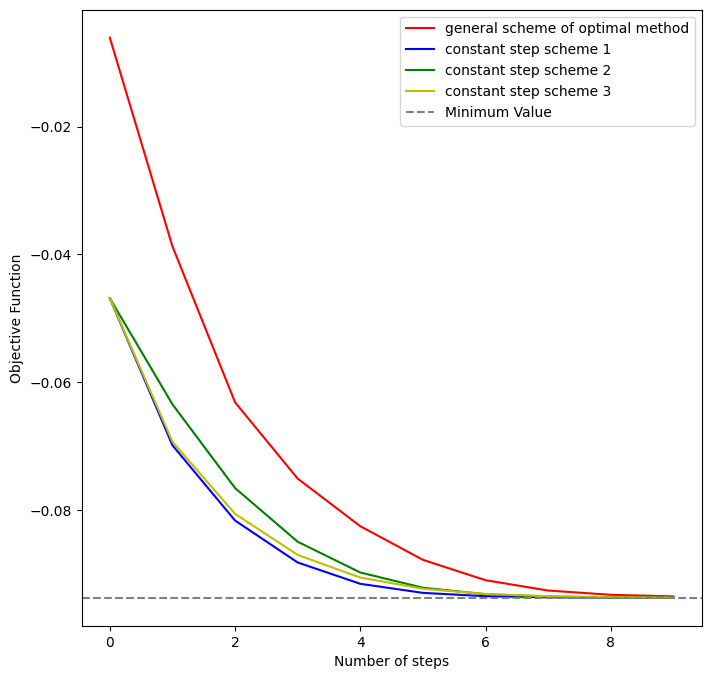

In [16]:
# Draw the objective function's value changes with the steps

Plotting_Scale = 10
actual_coordinates = int(max_iters / Plotting_Scale)

plt.figure(figsize=(8, 8))

plt.xlabel('Number of steps')

plt.ylabel('Objective Function')

plt.plot(range(actual_coordinates), general_obj[:actual_coordinates],
         'r', label='general scheme of optimal method')

plt.plot(range(actual_coordinates), constant_1_obj[:actual_coordinates],
         'b', label='constant step scheme 1')

plt.plot(range(actual_coordinates), constant_2_obj[:actual_coordinates],
         'g', label='constant step scheme 2')
plt.plot(range(actual_coordinates), constant_3_obj[:actual_coordinates],
         'y', label='constant step scheme 3')

plt.axhline(y=y_best, color='grey', linestyle='--', label='Minimum Value')
plt.legend(loc='upper right')

plt.show()

In [17]:
# Variation of optimization results with other variables when fixing one parameter.

# Attention: The calculations here are very resource-intensive, so please don't over-parameter them!
from ipywidgets import interact
import matplotlib.pyplot as plt

# Choose the maximum number and minimun number of X

MAX_INIT_X_1 = 10.0
MIN_INIT_X_1 = -10.0
MAX_INIT_X_2 = 10.0
MIN_INIT_X_2 = -10.0
MAX_INIT_X_3 = 10.0
MIN_INIT_X_3 = -10.0
MIN_ITER = 10
MAX_ITER = 50

# Describe the plotting accuracy
num_intervals = 20
gamma_0 = 0.0
learning_rate = 0.2

def draw_counter_plot(fix, fixed_number, iterations):
    x_1 = np.linspace(MAX_INIT_X_1, MIN_INIT_X_1, num_intervals)
    x_2 = np.linspace(MAX_INIT_X_2, MIN_INIT_X_2, num_intervals)
    x_3 = np.linspace(MAX_INIT_X_3, MIN_INIT_X_3, num_intervals)

    iter = iterations
    x_left_name = ''
    x_right_name = ''
    x_left = np.array([])
    x_right = np.array([])
    Y = np.zeros(num_intervals)
    # Calculate the result.

    def calculate_finial_value(x_left, x_right, x_fixed, gd):
        for xl_row, xr_row in zip(x_left, x_right):
            temp = []
            for xl, xr in zip(xl_row, xr_row):
                t1, t2 = gd(x_fixed)(xl)(xr)
                temp.append(t1[-1])
            yield temp

    # Use damping step as the h
    optim_method = damping_step_generator(lr=learning_rate)

    # Fix variables by parameters.
    match fix:
        case 'x1':
            x_left_name = 'x2'
            x_right_name = 'x3'
            x_left, x_right = np.meshgrid(x_2, x_3)
            x_fixed = fixed_number
            # Calculate the result.

            def gd1(x1): return lambda x2: lambda x3: general_scheme_of_optimal_method(
                np.array([x1, x2, x3]), gamma_0, iter, objective_function, optim_method, is_log=False)
            Y = np.array([item for item in calculate_finial_value(
                x_left, x_right, x_fixed, gd1)])
        case 'x2':
            x_left_name = 'x3'
            x_right_name = 'x1'
            x_left, x_right = np.meshgrid(x_3, x_1)
            x_fixed = fixed_number
            # Calculate the result.

            def gd2(x1): return lambda x2: lambda x3: general_scheme_of_optimal_method(
                np.array([x3, x1, x2]), gamma_0, iter, objective_function, optim_method, is_log=False)
            Y = np.array([item for item in calculate_finial_value(
                x_left, x_right, x_fixed, gd2)])
        case 'x3':
            x_left_name = 'x1'
            x_right_name = 'x2'
            x_left, x_right = np.meshgrid(x_1, x_2)
            x_fixed = fixed_number
            # Calculate the result.

            def gd3(x1): return lambda x2: lambda x3: general_scheme_of_optimal_method(
                np.array([x2, x3, x1]), gamma_0, iter, objective_function, optim_method, is_log=False)
            Y = np.array([item for item in calculate_finial_value(
                x_left, x_right, x_fixed, gd3)])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Draw the contour plot.
    surf = ax.plot_surface(x_left, x_right, Y, cmap='viridis',
                    edgecolor='none', alpha=0.8)
    # Set the title and label.
    ax.set_xlabel(f'{x_left_name}')
    ax.set_ylabel(f'{x_right_name}')
    ax.set_title(
        f'3D Contour Plot of Finial Value with Fixed {fix}')

    # Show the contour plot.
    plt.show()


# Creating an Interactive Interface.
interact(draw_counter_plot, fix=['x1', 'x2', 'x3'], fixed_number=(
    MIN_X_1, MAX_X_1), iterations=(MIN_ITER, MAX_ITER))

interactive(children=(Dropdown(description='fix', options=('x1', 'x2', 'x3'), value='x1'), FloatSlider(value=0…

<function __main__.draw_counter_plot(fix, fixed_number, iterations)>